В качестве домашнего задания мы предлагаем вам решить задачу бинарной классификации на большом корпусе imdb рецензий на фильмы. 
Корпус можно скачать по ссылке http://ai.stanford.edu/~amaas/data/sentiment/

Ваша задача в sklearn, используя один из алгоритмов, рассмотренных на паре, построить и обучить классификатор, посчитать метрики качества (precision, recall, F-мера), построить ROC кривую и посчитайте величину ROC AUC.  - 4 балла

Используя предсказания вероятностей класса, найдите 15 самых негативных и самых позитивных рецензий по мнению модели.  - 3 балла

Написать свои функции, которые бы считали tp, fp, tn, fn, и возвращали точность, полноту и ф-меру и применить их к результатам, полученным вашими классификаторами (если все сделано правильно, то результаты должны совпадать с полученными  sklearn метриками). - 3 балла

In [1]:
import os
import random
import numpy as np

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!gunzip aclImdb_v1.tar.gz
!tar -xvf aclImdb_v1.tar

In [3]:
#@title
#@Data_downloading
#this code was taken from https://developers.google.com/machine-learning/guides/text-classification/step-2


def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [13]:
train_data, test_data = load_imdb_sentiment_analysis_dataset('')

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data[0]) #Learn the vocabulary dictionary and return term-document matrix.
X_test = count_vect.transform(test_data[0])

In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2000).fit(X_train_counts, train_data[1])
predicted = clf.predict(X_test)
predicted_score = clf.score(X_train_counts, train_data[1])

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
from matplotlib import pyplot

In [17]:
sklearn_acc = accuracy_score(test_data[1], predicted)
sklearn_f1 = f1_score(test_data[1], predicted)
sklearn_precision = precision_score(test_data[1], predicted)
sklearn_recall = recall_score(test_data[1], predicted)

print('acc={0:1.4f}'.format(sklearn_acc))
print('F1={0:1.4f}, P={1:1.4f}, R={2:1.4f}'.format(sklearn_f1, sklearn_precision, sklearn_recall))

acc=0.8667
F1=0.8657, P=0.8726, R=0.8588


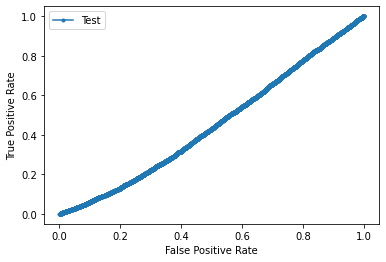

In [18]:
y_true = test_data[1]
y_predicted = predicted
y_predicted_proba = clf.predict_proba(X_test)
y_predicted_score = [max(i) for i in y_predicted_proba]
fpr, tpr, thrhld = roc_curve(y_true, y_predicted_score)
pyplot.plot(fpr, tpr, marker='.', label='Test')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [19]:
print(f'roc auc score: {roc_auc_score(y_true, y_predicted_score)}')

roc auc score: 0.4515235872


(array([  533.,   569.,   580.,   596.,   697.,   741.,   883.,  1261.,
         1977., 17163.]),
 array([0.50031127, 0.55028015, 0.60024902, 0.65021789, 0.70018676,
        0.75015564, 0.80012451, 0.85009338, 0.90006225, 0.95003113,
        1.        ]),
 <a list of 10 Patch objects>)

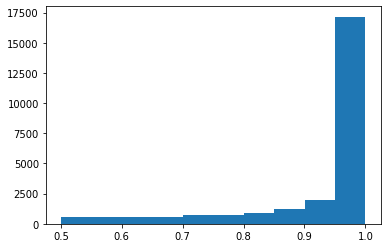

In [27]:
#Видимо, такой плохой рок аук у нас получился из-за небалансированности классов
pyplot.hist(y_predicted_score)

In [28]:
def tp(y_predicted, y_true):
    tp = 0
    for i in range(len(y_true)):
        if y_true[i]==1 and y_predicted[i]==1:
            tp+=1
    return tp


def tn(y_predicted, y_true):
    tn = 0
    for i in range(len(y_true)):
        if y_true[i]==0 and y_predicted[i]==0:
            tn+=1
    return tn


def fp(y_predicted, y_true):
    fp = 0
    for i in range(len(y_true)):
        if y_true[i]==0 and y_predicted[i]==1:
            fp+=1
    return fp


def fn(y_predicted, y_true):
    fn = 0
    for i in range(len(y_true)):
        if y_true[i]==1 and y_predicted[i]==0:
            fn+=1
    return fn


def my_accuracy(y_predicted, y_true):
    return (tp(y_predicted, y_true) + tn(y_predicted, y_true))/(tp(y_predicted, y_true) + tn(y_predicted, y_true) + 
            fp(y_predicted, y_true) + fn(y_predicted, y_true))


def my_precision(y_predicted, y_true):
    return tp(y_predicted, y_true)/(tp(y_predicted, y_true) + fp(y_predicted, y_true))


def my_recall(y_predicted, y_true):
    return tp(y_predicted, y_true)/(tp(y_predicted, y_true)+fn(y_predicted, y_true))


def my_f(y_predicted, y_true):
    return 2*my_precision(y_predicted, y_true)*my_recall(y_predicted, y_true)/(my_precision(y_predicted, y_true) + my_recall(y_predicted, y_true))

In [29]:
print('F1={0:1.4f}, P={1:1.4f}, R={2:1.4f}'.format(sklearn_f1, sklearn_precision, sklearn_recall))
print('These are sklearn metrics:')
print(f'F1={sklearn_f1}, P={sklearn_precision}, R={sklearn_recall}')
print('These are my metrics:')
print(f'F1={my_f(y_predicted, y_true)}, P={my_precision(y_predicted, y_true)}, R={my_recall(y_predicted, y_true)}')
print('\nThis is catapillar:')
print('╚═( ͡° ͜ʖ ͡°)═╝\n╚═(███)═╝\n╚═(███)═╝\n.╚═(███)═╝\n..╚═(███)═╝\n.╚═(███)═╝\n╚═(███)═╝\n.╚═(███)═╝\n..╚═(███)═╝\n…╚═(███)═╝\n…╚═(███)═╝\n…..╚(███)╝\n……╚(██)╝\n………(█)')

F1=0.8657, P=0.8726, R=0.8588
These are sklearn metrics:
F1=0.8656559954842351, P=0.872622337831247, R=0.8588
These are my metrics:
F1=0.8656559954842351, P=0.872622337831247, R=0.8588

This is catapillar:
╚═( ͡° ͜ʖ ͡°)═╝
╚═(███)═╝
╚═(███)═╝
.╚═(███)═╝
..╚═(███)═╝
.╚═(███)═╝
╚═(███)═╝
.╚═(███)═╝
..╚═(███)═╝
…╚═(███)═╝
…╚═(███)═╝
…..╚(███)╝
……╚(██)╝
………(█)
